In [1]:
import warnings
warnings.simplefilter('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.linear_model import BayesianRidge, ARDRegression, Lasso, Ridge
from sklearn.ensemble import BaggingRegressor, AdaBoostRegressor, RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
df = pd.read_csv('processed_dataset.csv')
df.head()

,Course Code,Course Title,Student Number,Department Code,Course Level,Letter Grade,Status,GPA,Standing,Completed Credits,Completed ECTS,GPA Student - Subject,Avg. Grade - Taken,Avg. Grade - Students_Subject,Semester,Theoritical,Practical,Course Credit,ECTS,Course Year
0,UNI 123,Textual Analysis and Effective Communication,351,IE,Undergraduate,A+,Successful,4.05,Freshman,18,30,4.05,2.120833,2.703226,2011 - Fall,3,0,3,5,1
1,MGT 511,Küresel Yönetim Düşüncesi,1182,MBA/NT,Graduate,A-,Successful,3.54,Freshman,15,25,3.54,3.576471,3.324211,2011 - Fall,3,0,3,5,5
2,MGT 521,Yönetim ve Organizasyon,1182,MBA/NT,Graduate,B+,Successful,3.54,Freshman,15,25,3.54,3.371429,3.324211,2011 - Fall,3,0,3,5,5
3,MGT 521,Yönetim ve Organizasyon,1181,MBA/NT,Graduate,B+,Successful,3.38,Freshman,15,25,3.38,3.371429,3.324211,2011 - Fall,3,0,3,5,5
4,MGT 531,Stratejik Yönetim,1181,MBA/NT,Graduate,B+,Successful,3.38,Freshman,15,25,3.38,3.227273,3.324211,2011 - Fall,3,0,3,5,5


In [3]:
df.drop([df.columns[0], df.columns[1], df.columns[2]], inplace=True, axis=1)   # dropping course details

In [4]:
df = pd.concat([df, pd.get_dummies(df['Course Year'], prefix='Course Year'), pd.get_dummies(df['Department Code'], prefix='Department Code'), pd.get_dummies(df['Course Level'], prefix='Course Level'), pd.get_dummies(df['Standing'], prefix='Standing'), pd.get_dummies(df['Status'], prefix='Status')], axis=1)
df.drop(['Course Year', 'Department Code', 'Course Level', 'Status', 'Standing'], axis=1, inplace=True)

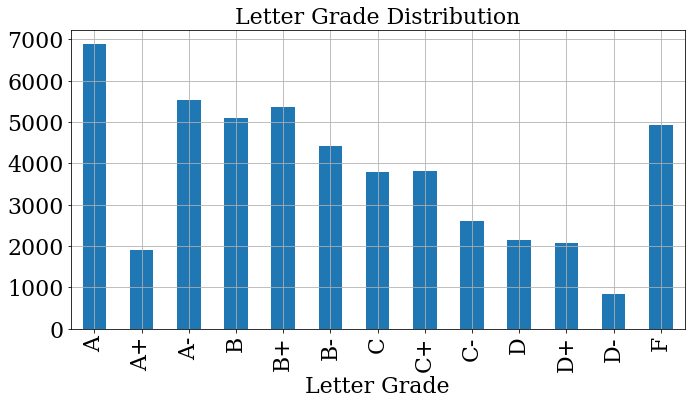

In [5]:
df[['Letter Grade', 'Semester']].groupby('Letter Grade', as_index=False).count().plot('Letter Grade', 'Semester', kind='bar', figsize=(11, 5.5), legend=False, grid=True)
plt.title('Letter Grade Distribution', fontsize=22, fontfamily='serif')
plt.xlabel('Letter Grade', fontsize=22, fontfamily='serif')
plt.xticks(fontfamily='serif', fontsize=22)
plt.yticks(fontfamily='serif', fontsize=22)
plt.show()

In [6]:
columns = df.columns

In [7]:
le = LabelEncoder()
le.fit(['A+', 'A', 'A-', 'B+', 'B', 'B-', 'C+', 'C', 'C-', 'D+', 'D', 'D-', 'F'])

LabelEncoder()

In [8]:
def get_train_data(df, train_sem, columns):
    dataFrame = pd.DataFrame(columns=columns)
    for sem in train_sem:
        dataFrame = pd.concat([dataFrame, df[df.iloc[:, 7] == sem]], ignore_index=True)
    for idx in dataFrame.index:
        semester = dataFrame.iloc[idx, 7]
        dataFrame.iloc[idx, 7] = semester.split()[2].strip()
    
    X_train = dataFrame.drop('Semester', axis=1)
    y_train = le.transform(X_train.pop('Letter Grade'))
    return X_train, y_train

In [9]:
def normalize_X(X):
    cols = X.columns
    sc = StandardScaler()
    X = sc.fit_transform(X)
    return pd.DataFrame(X, columns=cols)

In [10]:
def get_error_score(df, columns, model):
    error_scores = {}
    sorted_semesters = sorted(set(df.iloc[:, 7]))
    for sem_idx in range(1, len(sorted_semesters)):
        training_sem = sorted_semesters[:sem_idx]
        test_sem = sorted_semesters[sem_idx]
        X_train, y_train = get_train_data(df, training_sem, columns)
        X_test = df[df.iloc[:, 7] == test_sem]
        X_test.drop('Semester', axis=1, inplace=True)
        y_test = le.transform(X_test.pop('Letter Grade'))
        
        X_train = normalize_X(X_train)
        X_test = normalize_X(X_test)
        model.fit(X_train, y_train)
        
        y_pred_test = model.predict(X_test)
        rmse_test = round(np.sqrt(mean_squared_error(y_test, y_pred_test)), 3)
        r2_test = round(r2_score(y_test, y_pred_test), 3)
        
        y_pred_train = model.predict(X_train)
        rmse_train = round(np.sqrt(mean_squared_error(y_train, y_pred_train)), 3)
        r2_train = round(r2_score(y_train, y_pred_train),3)
        
        error_scores.setdefault(sem_idx, {})
        error_scores[sem_idx]['rmse'] = [rmse_train, rmse_test]
        error_scores[sem_idx]['r2'] = [r2_train, r2_test]        
        
    return error_scores

In [11]:
def plot_error_score(scores, model_name):
    errors = {}
    for k in sorted(scores):
        for metric in scores[k]:
            errors.setdefault(metric + ' train', [])
            errors[metric + ' train'].append(scores[k][metric][0])
            errors.setdefault(metric + ' test', [])
            errors[metric + ' test'].append(scores[k][metric][1])
    
    x = np.arange(7)
    fig, ax = plt.subplots(figsize=(15, 6))
    rects1 = ax.bar(x - 3*0.15/2, errors['rmse test'], 0.15, label='RMSE - test')
    rects2 = ax.bar(x - 0.15/2, errors['rmse train'], 0.15, label='RMSE - train')
    rects4 = ax.bar(x + 0.15/2, errors['r2 train'], 0.15, label='R\u00b2 Statistics - train')
    rects3 = ax.bar(x + 3*0.15/2, errors['r2 test'], 0.15, label='R\u00b2 Statistics - test')
    
    for i, v in enumerate(errors['rmse test']):
        ax.text(i-0.28, v + 0.07, str(round(v, 2)), fontfamily='serif', fontsize=13, fontweight='bold', rotation=90)
    
    for i, v in enumerate(errors['rmse train']):
        ax.text(i-0.12, v + 0.07, str(round(v, 2)), fontfamily='serif', fontsize=13, fontweight='bold', rotation=90)
    
    for i, v in enumerate(errors['r2 train']):
        ax.text(i+0.025, v + 0.07, str(round(v, 2)), fontfamily='serif', fontsize=13, fontweight='bold', rotation=90)

    for i, v in enumerate(errors['r2 test']):
        ax.text(i+0.18, v + 0.07, str(round(v, 2)), fontfamily='serif', fontsize=13, fontweight='bold', rotation=90)

    ax.set_ylabel('Error', fontsize=22, fontfamily='serif')
    ax.set_title('Error Metrics with N training semesters - ({})'.format(model_name), fontsize=22, fontfamily='serif')
    ax.set_ylim(top=list(ax.get_ylim())[1]+0.5)
    ax.set_xticks(x)
    ax.set_xticklabels(['N={}'.format(i+1) for i in range(7)], fontsize=22, fontfamily='serif')
    ax.set_yticklabels(ax.get_yticks(), fontsize=22, fontfamily='serif')
    ax.tick_params(labelsize=22)
    ax.grid(True)
    ax.legend(prop={'size': 17, 'family': 'serif'}, loc='center', bbox_to_anchor=(0.5, -0.15), ncol=4)

# Tree Models:
### DecisionTreeRegressor:
* Observations: The model clearly overfits. Hyperparameter tuning shall be applied in next round of analysis.

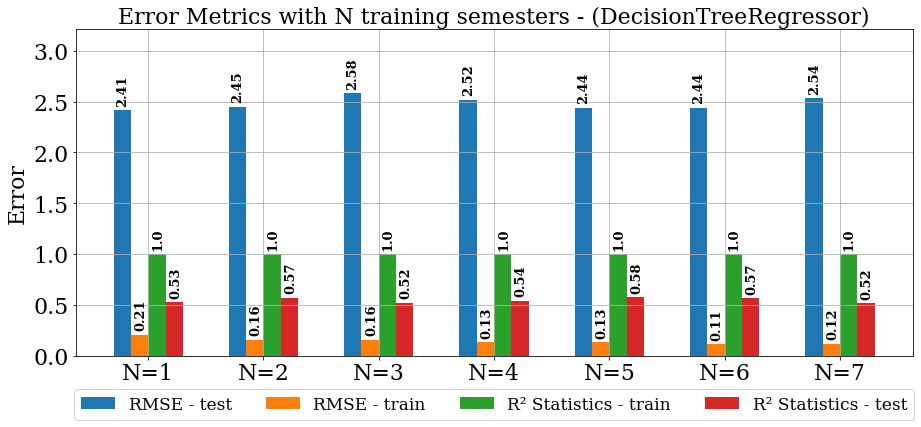

In [12]:
scores = get_error_score(df, columns, DecisionTreeRegressor())
plot_error_score(scores, 'DecisionTreeRegressor')

# Neighbor Models:
### KNeighborsRegressor:
* Observations: The model almost generalizes to the test data but there is high bias.

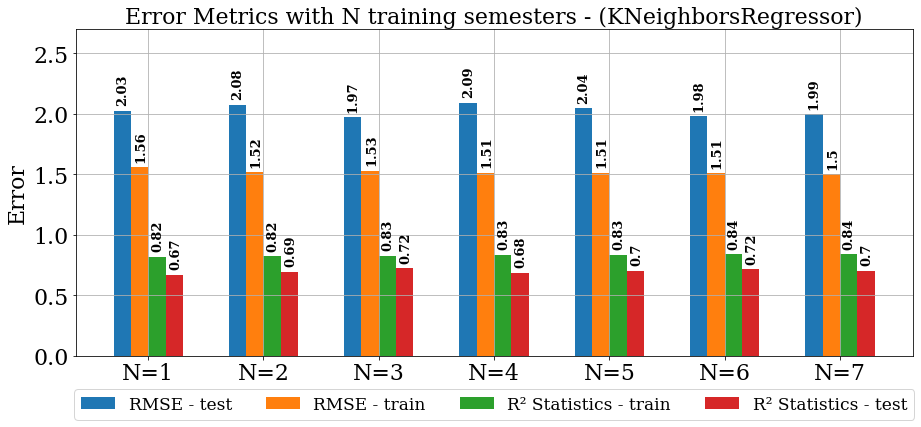

In [13]:
scores = get_error_score(df, columns, KNeighborsRegressor())
plot_error_score(scores, 'KNeighborsRegressor')

# Support Vector Machines:
### Support Vector Regressor:
* Observations: The model does not overfit, but there is high bias.

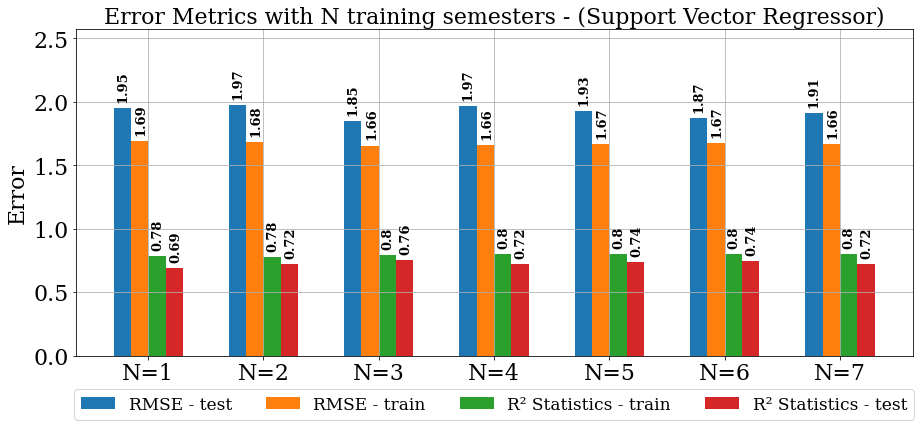

In [14]:
scores = get_error_score(df, columns, SVR())
plot_error_score(scores, 'Support Vector Regressor')

# Linear Models:
### BayesianRidge:
* Observations: The model does not overfit, but there is high bias.

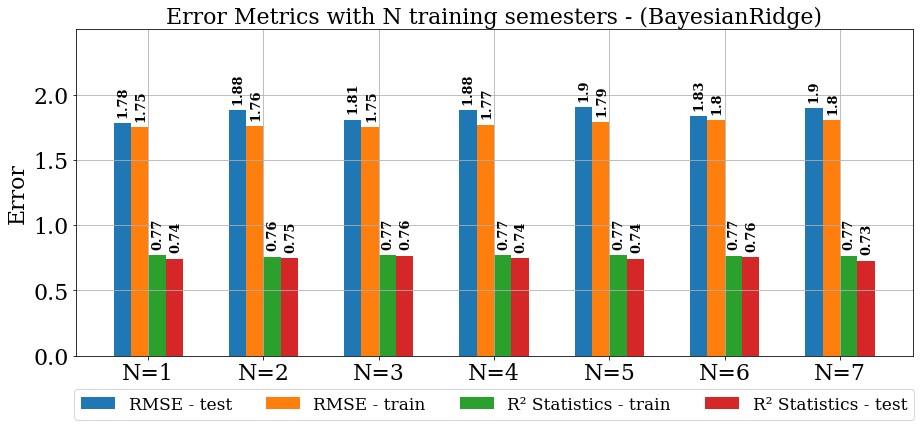

In [15]:
scores = get_error_score(df, columns, BayesianRidge())
plot_error_score(scores, 'BayesianRidge')

### ARDRegression:
* Observations: The model does not overfit but there is high bias.

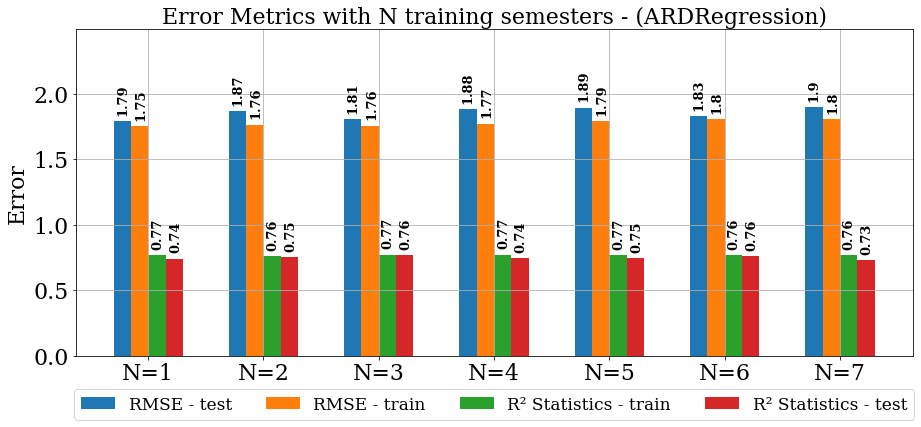

In [16]:
scores = get_error_score(df, columns, ARDRegression())
plot_error_score(scores, 'ARDRegression')

### Lasso:
* Observations: The model does not overfit but there is high bias.

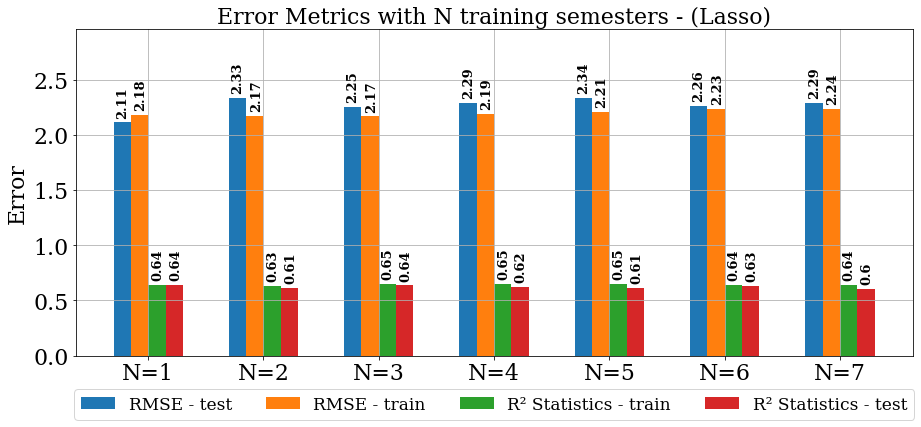

In [17]:
scores = get_error_score(df, columns, Lasso())
plot_error_score(scores, 'Lasso')

### Ridge:
* Observations: The model does not overfit but there is high bias.

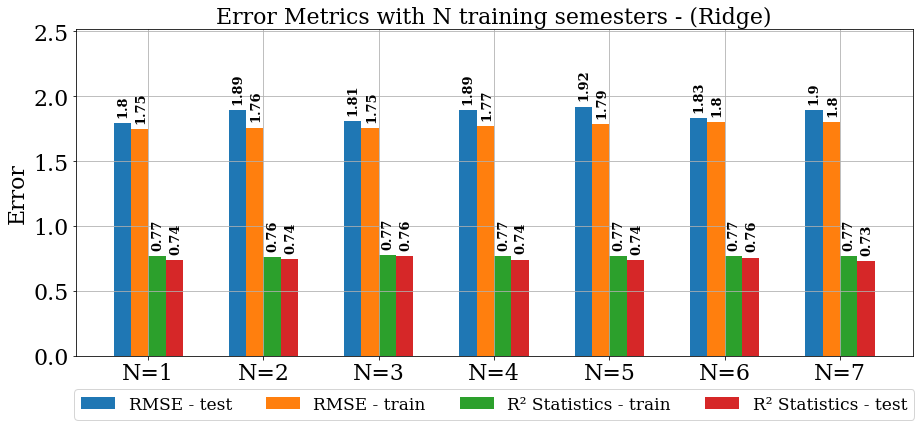

In [18]:
scores = get_error_score(df, columns, Ridge())
plot_error_score(scores, 'Ridge')

# Ensemble Models:
### BaggingRegressor:
* Observations: The model has both, high bias and variance.

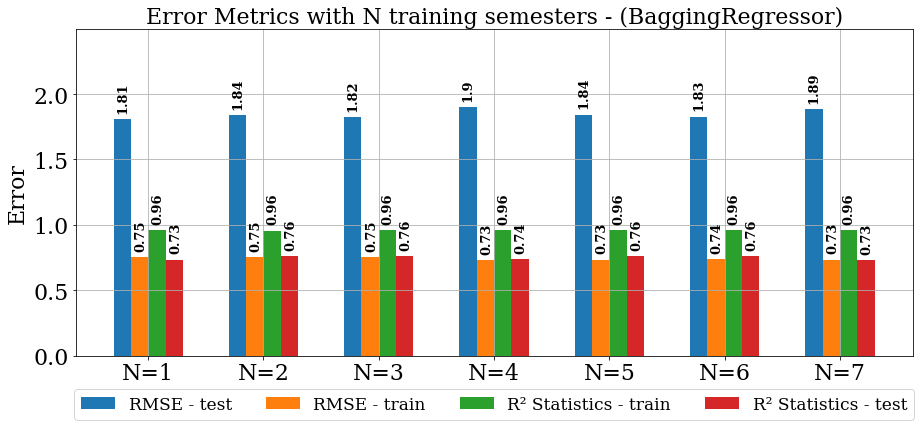

In [19]:
scores = get_error_score(df, columns, BaggingRegressor())
plot_error_score(scores, 'BaggingRegressor')

### AdaBoostRegressor:
* Observations: The model does not overfit but there is high bias.

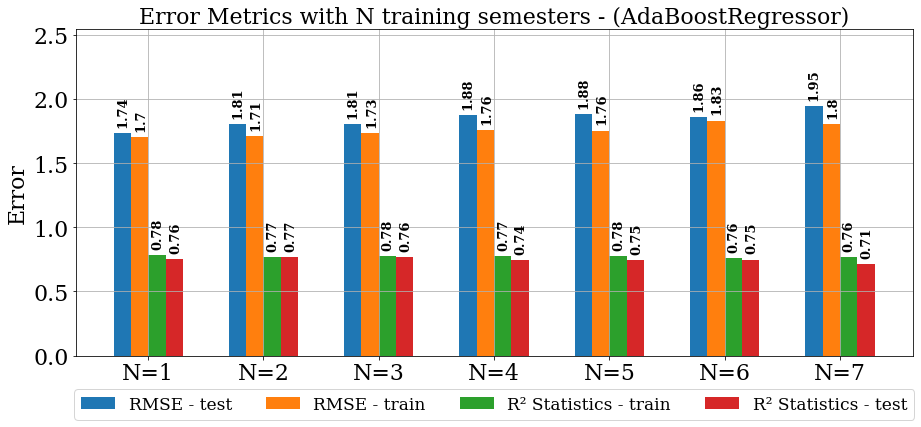

In [20]:
scores = get_error_score(df, columns, AdaBoostRegressor())
plot_error_score(scores, 'AdaBoostRegressor')

### RandomForestRegressor:
* Observations: The model has both, high bias and variance.

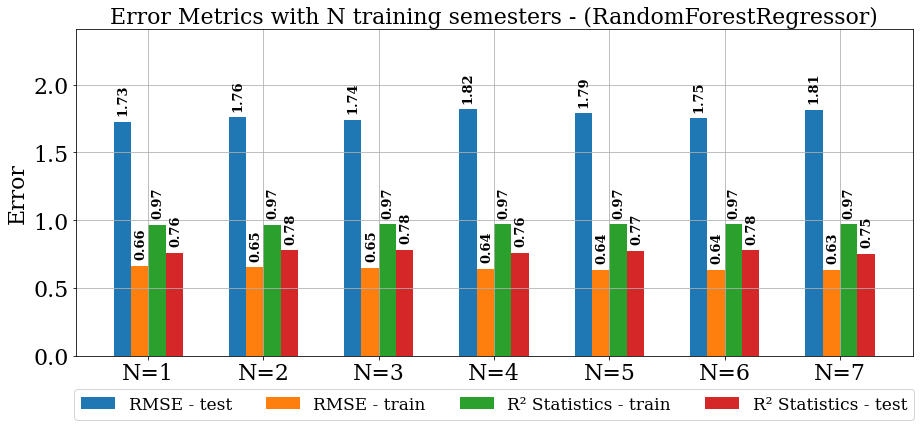

In [21]:
scores = get_error_score(df, columns, RandomForestRegressor())
plot_error_score(scores, 'RandomForestRegressor')

### GradientBoostingRegressor:
* Observations: The model does not overfit but there is high bias.

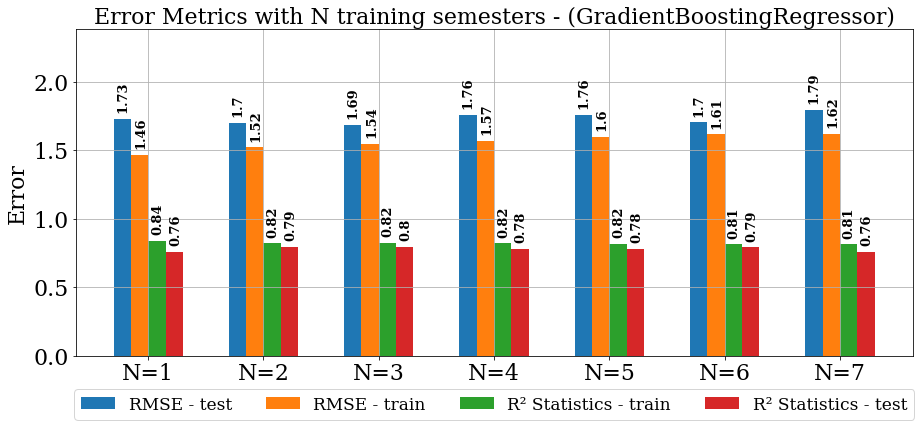

In [22]:
scores = get_error_score(df, columns, GradientBoostingRegressor())
plot_error_score(scores, 'GradientBoostingRegressor')